In [ ]:
import gym
import random
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from collections import namedtuple, deque
from ale_py import ALEInterface
import wandb
import imageio
import matplotlib.pyplot as plt
from utils_AC_gray import *
import os
import tensorflow as tf
import warnings
import logging



In [1]:


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 0 = all messages, 1 = filter out INFO, 2 = filter out WARNING, 3 = filter out ERROR
tf.get_logger().setLevel('ERROR')

warnings.filterwarnings('ignore')


gym_logger = logging.getLogger('gym')
gym_logger.setLevel(logging.ERROR)

In [2]:
import wandb
wandb.init(project="ActorCritic grayscale", entity = "rl_proj")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: roysgc (rl_proj). Use `wandb login --relogin` to force relogin


In [6]:

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

ale = ALEInterface()


config = Config()
best_reward = 0

#env = gym.make("Assault-v4", render_mode="rgb_array")
env = gym.make("Assault-v4") 
n_actions = env.action_space.n


actor_model = Actor(n_actions)

critic_model = Critic()

def rgb_to_grayscale(rgb):
    return np.dot(rgb[..., :3], [0.2989, 0.5870, 0.1140])

actor_model.build(input_shape=(None, 210, 160, 1))  # 1 channel for grayscale
critic_model.build(input_shape=(None, 210, 160, 1))

dummy_input = np.random.random((1, 210, 160, 1))  # Updated for grayscale
actor_model(dummy_input)
critic_model(dummy_input)

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=10000,
    decay_rate=0.9)
actor_optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
critic_optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

memory = ReplayMemory(config.MEMORY_SIZE)



episode_rewards = []
epsilon = config.EPSILON_START

for episode in range(config.EPISODES):
    state= env.reset()

    state = rgb_to_grayscale(state) / 255.0
    state = state.reshape(1, 210, 160, 1)  # Correctly reshape

    done = False
    episode_reward = 0
    steps = 0
    info ={'ale.lives': 4, 'episode_frame_number': 2, 'frame_number': 2}
    frames = []
    

    while not done and info.get("ale.lives") >= 0: #steps < config.MAX_STEPS_PER_EPISODE and info.get("lives") >= 0:
        action = take_action(state, epsilon, env, actor_model, n_actions)
        
        step_result = env.step(action)
        
        next_state, reward, done, info = step_result

        next_state = rgb_to_grayscale(next_state) / 255.0
        next_state = next_state.reshape(1, 210, 160, 1)  

        memory.push(state, action, next_state, reward, done)
        optimize_model(memory, config, critic_model, critic_optimizer, actor_model, actor_optimizer, n_actions)

        frame = env.render(mode="rgb_array")
        frames.append(frame)

        state = next_state
        episode_reward += reward

        if reward != 0:
            print("step: ", steps, "action: ", action, " reward: ", reward)
            print("Lives: ", info.get("ale.lives"))

        steps += 1

    print(f"Episode: {episode+1}, Reward: {episode_reward}, Epsilon: {epsilon}")

    if episode_reward > best_reward:
        best_reward = episode_reward

        actor_model.save("./best_actor_model", save_format="tf")
        
        critic_model.save("./best_critic_model", save_format="tf")
        print("New best model saved with reward:", episode_reward)

        gif_path = f"./episode_{episode+1}_reward_{episode_reward}.gif"
        
        imageio.mimsave(gif_path, frames, duration=20)

    episode_rewards.append(episode_reward)

    epsilon = max((epsilon * config.EPSILON_DECAY_RATE), config.EPSILON_END)

    # Log episode metrics and GIF to wandb
    wandb.log({"episode": episode + 1, "reward": episode_reward, "epsilon": epsilon, "episode_gif": wandb.Video(gif_path, fps=4, format="gif")})

env.close()
plot_rewards(episode_rewards)



step:  68 action:  2  reward:  21.0
Lives:  4
step:  99 action:  1  reward:  21.0
Lives:  3
step:  154 action:  2  reward:  21.0
Lives:  3
step:  290 action:  3  reward:  21.0
Lives:  2
step:  320 action:  4  reward:  21.0
Lives:  2
step:  343 action:  2  reward:  21.0
Lives:  2
step:  451 action:  4  reward:  21.0
Lives:  1
step:  459 action:  4  reward:  21.0
Lives:  1
step:  494 action:  5  reward:  21.0
Lives:  1
Episode: 1, Reward: 189.0, Epsilon: 1.0


New best model saved with reward: 189.0
step:  34 action:  6  reward:  21.0
Lives:  4
step:  52 action:  2  reward:  21.0
Lives:  4
1/1 [==============================] - 0s 171ms/step
step:  89 action:  2  reward:  21.0
Lives:  4
1/1 [==============================] - 0s 27ms/step
step:  96 action:  1  reward:  21.0
Lives:  4
step:  131 action:  1  reward:  21.0
Lives:  3
step:  146 action:  0  reward:  21.0
Lives:  3
step:  199 action:  6  reward:  21.0
Lives:  3
step:  279 action:  0  reward:  21.0
Lives:  2
1/1 [==============================] - 0s 31ms/step
step:  317 action:  5  reward:  21.0
Lives:  2
1/1 [==============================] - 0s 29ms/step
step:  368 action:  1  reward:  21.0
Lives:  1
Episode: 2, Reward: 210.0, Epsilon: 0.99


New best model saved with reward: 210.0
1/1 [==============================] - 0s 27ms/step
step:  19 action:  0  reward:  21.0
Lives:  4
1/1 [==============================] - 0s 24ms/step
step:  60 action:  1  reward:  21.0
Lives:  4
1/1 [==============================] - 0s 33ms/step
step:  124 action:  1  reward:  21.0
Lives:  4
1/1 [==============================] - 0s 25ms/step
step:  158 action:  6  reward:  21.0
Lives:  4
step:  174 action:  4  reward:  21.0
Lives:  4
1/1 [==============================] - 0s 26ms/step
step:  300 action:  5  reward:  21.0
Lives:  3
1/1 [==============================] - 0s 25ms/step
step:  644 action:  2  reward:  21.0
Lives:  1
step:  662 action:  2  reward:  21.0
Lives:  1
step:  668 action:  2  reward:  21.0
Lives:  1
1/1 [==============================] - 0s 25ms/step
Episode: 3, Reward: 189.0, Epsilon: 0.9801
step:  20 action:  6  reward:  21.0
Lives:  4
1/1 [==============================] - 0s 27ms/step
step:  98 action:  2  reward:  21.

New best model saved with reward: 273.0
step:  14 action:  2  reward:  21.0
Lives:  4
step:  22 action:  2  reward:  21.0
Lives:  4
step:  31 action:  1  reward:  21.0
Lives:  4
1/1 [==============================] - 0s 26ms/step
step:  92 action:  6  reward:  21.0
Lives:  4
1/1 [==============================] - 0s 27ms/step
step:  141 action:  2  reward:  21.0
Lives:  4
1/1 [==============================] - 0s 32ms/step
step:  280 action:  3  reward:  21.0
Lives:  3
1/1 [==============================] - 0s 25ms/step
step:  322 action:  2  reward:  21.0
Lives:  3
1/1 [==============================] - 0s 26ms/step
step:  341 action:  5  reward:  21.0
Lives:  3
step:  364 action:  1  reward:  21.0
Lives:  3
step:  382 action:  6  reward:  21.0
Lives:  3
1/1 [==============================] - 0s 26ms/step
step:  508 action:  2  reward:  21.0
Lives:  2
1/1 [==============================] - 0s 24ms/step
step:  552 action:  6  reward:  21.0
Lives:  2
1/1 [==============================]

New best model saved with reward: 399.0
1/1 [==============================] - 0s 34ms/step
step:  96 action:  4  reward:  21.0
Lives:  4
1/1 [==============================] - 0s 26ms/step
step:  125 action:  6  reward:  21.0
Lives:  4
1/1 [==============================] - 0s 26ms/step
step:  142 action:  4  reward:  21.0
Lives:  4
step:  172 action:  1  reward:  21.0
Lives:  4
step:  196 action:  1  reward:  21.0
Lives:  4
step:  236 action:  3  reward:  21.0
Lives:  4
1/1 [==============================] - 0s 26ms/step
step:  335 action:  2  reward:  21.0
Lives:  3
1/1 [==============================] - 0s 26ms/step
step:  386 action:  3  reward:  21.0
Lives:  3
1/1 [==============================] - 0s 26ms/step
step:  431 action:  4  reward:  21.0
Lives:  3
1/1 [==============================] - 0s 26ms/step
step:  494 action:  2  reward:  21.0
Lives:  2
1/1 [==============================] - 0s 30ms/step
step:  599 action:  0  reward:  21.0
Lives:  2
1/1 [=======================

New best model saved with reward: 441.0
1/1 [==============================] - 0s 38ms/step
step:  21 action:  3  reward:  21.0
Lives:  4
1/1 [==============================] - 0s 26ms/step
step:  81 action:  3  reward:  21.0
Lives:  4
step:  103 action:  0  reward:  21.0
Lives:  4
1/1 [==============================] - 0s 25ms/step
step:  150 action:  5  reward:  21.0
Lives:  4
1/1 [==============================] - 0s 25ms/step
step:  172 action:  3  reward:  21.0
Lives:  4
1/1 [==============================] - 0s 25ms/step
step:  235 action:  2  reward:  21.0
Lives:  3
1/1 [==============================] - 0s 25ms/step
step:  356 action:  1  reward:  21.0
Lives:  2
1/1 [==============================] - 0s 27ms/step
step:  393 action:  3  reward:  21.0
Lives:  2
1/1 [==============================] - 0s 28ms/step
step:  405 action:  5  reward:  21.0
Lives:  2
1/1 [==============================] - 0s 26ms/step
step:  564 action:  3  reward:  21.0
Lives:  1
1/1 [===================

KeyboardInterrupt: 

1/1 [==============================] - 0s 27ms/step
action:  2  reward:  21.0
Lives:  4
1/1 [==============================] - 0s 24ms/step
action:  2  reward:  21.0
Lives:  4
1/1 [==============================] - 0s 24ms/step
action:  2  reward:  21.0
Lives:  4
1/1 [==============================] - 0s 23ms/step
action:  2  reward:  21.0
Lives:  4
1/1 [==============================] - 0s 22ms/step
action:  2  reward:  21.0
Lives:  4
1/1 [==============================] - 0s 22ms/step
action:  2  reward:  21.0
Lives:  4
1/1 [==============================] - 0s 22ms/step
action:  2  reward:  21.0
Lives:  3
1/1 [==============================] - 0s 23ms/step
action:  2  reward:  21.0
Lives:  3
1/1 [==============================] - 0s 21ms/step
action:  2  reward:  21.0
Lives:  3
1/1 [==============================] - 0s 20ms/step
action:  2  reward:  21.0
Lives:  3
1/1 [==============================] - 0s 21ms/step
action:  2  reward:  21.0
Lives:  2
1/1 [===========================

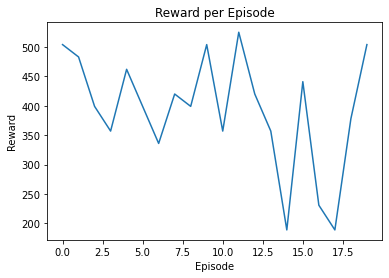

<Figure size 432x288 with 0 Axes>

In [7]:

#TEST THE SAVED MODEL
import gym
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

actor_model = keras.models.load_model("./best_actor_model")

critic_model = keras.models.load_model("./best_critic_model")

env = gym.make("Assault-v4")
n_actions = env.action_space.n

def take_action(state):
    action_probabilities = actor_model.predict(state)
    return np.random.choice(n_actions, p=np.squeeze(action_probabilities))


rewards_per_episode = []
best_reward = 0

for episode in range(20):
    state= env.reset()
    #state = state / 255.0 
    state = rgb_to_grayscale(state) / 255.0
    state = state.reshape(1, 210, 160, 1)  # Correctly reshape
    done = False
    episode_reward = 0
    frames = []
    info ={'ale.lives': 4, 'episode_frame_number': 2, 'frame_number': 2}

    while not done:
        action = take_action(state, actor_model, n_actions)
        next_state, reward, done, info = env.step(action)
        
        next_state = rgb_to_grayscale(next_state) / 255.0
        next_state = next_state.reshape(1, 210, 160, 1)  # Correctly reshape
        #next_state = next_state / 255.0  # Normaliza los valores de píxeles

        frame = env.render(mode = "rgb_array")
        frames.append(frame)

        state = next_state
        episode_reward += reward

        if reward != 0:
            print("action: ", action, " reward: ", reward)
            print("Lives: ", info.get("ale.lives"))

    rewards_per_episode.append(episode_reward)
    print(f"Episode {episode + 1}: Reward = {episode_reward}")

    if episode_reward > best_reward:
        best_reward = episode_reward  
        
        gif_path = f"./test_episode_{episode+1}_reward_{episode_reward}.gif"
        imageio.mimsave(gif_path, frames, fps=30)  

    # Log episode metrics and GIF to wandb
    wandb.log({"episode": episode + 1, "reward": episode_reward, "epsilon": epsilon, "episode_gif": wandb.Video(gif_path, fps=4, format="gif")})


env.close()

# Grafica las recompensas por episodio
plt.plot(rewards_per_episode)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Reward per Episode')
plt.show()

plot_path = "./test_rewards_plot.png"
plt.savefig(plot_path)


wandb.log({"Testing of Actor-Critic": wandb.Image(plot_path)})
